# Exercises XP Ninja: W4_D3

## What You Will Learn
- **CNN fundamentals:** architecture, convolution/pooling, and where CNNs fit in ML workflows.
- **Neural data preprocessing:** label encoding, feature scaling, train/validation/test splits.
- **Modeling with Keras:** building models using the high-level API.
- **Sequential API:** creating networks with `keras.Sequential()` (stacking layers).
- **Compile & train:** choosing loss/optimizer/metrics and running training loops with callbacks.
- **Evaluate models:** interpreting loss/accuracy and basic classification metrics.

## What You Will Create
- A **CNN model** in Keras to classify records from the provided dataset.
- A **preprocessing pipeline** tailored for neural networks (encoding + scaling).
- A **trained and evaluated** model with clear metrics (loss, accuracy; optionally precision/recall/F1).
- A concise, **reproducible** notebook documenting the end-to-end workflow.

## Dataset
Use the file: **`hr_comma_sep.xls`** (tabular HR attrition dataset).  
Typical columns include continuous features (e.g., satisfaction, evaluation, hours) and categorical features (e.g., department, salary), plus a binary target.

## Reading Material (for context)
- CNN overview (concepts): https://www.geeksforgeeks.org/deep-learning/convolutional-neural-network-cnn-in-machine-learning/  
- Keras tutorial (API usage): https://medium.com/analytics-vidhya/deep-learning-tutorial-with-keras-7a34a1a322cd

---

## Exercise 1 — Create a Simple Convolutional Neural Network (CNN)

**Instructions**
1. **Import** required libraries (NumPy, Pandas, scikit-learn) and **Keras** (`tensorflow.keras`).  
2. **Load** the dataset `hr_comma_sep.xls` (read as Excel; if needed, fallback to CSV).  
3. **Encode** labels and **preprocess** features:  
   - Impute missing values if any.  
   - One-Hot Encode categorical features.  
   - Standardize numeric features.  
4. **Split** the data into train/test (and optional validation split during training).  
5. **Build** a neural network using `keras.Sequential()` (you may use a 1D CNN or an MLP baseline):  
   - Example for CNN-1D on tabular data: `Conv1D` → `BatchNormalization` → `GlobalAveragePooling1D` → `Dense` head.  
6. **Compile** the model (e.g., `binary_crossentropy` + `Adam`) and **train** with early stopping (monitor validation loss).  
7. **Evaluate** the model on the test set: **loss** and **accuracy** (optionally print precision/recall/F1 and the confusion matrix).

**Deliverables**
- Clean, runnable notebook with:
  - Data loading + preprocessing cells.  
  - Model definition, compilation, and training logs.  
  - Final **test loss/accuracy** (and optionally precision/recall/F1 + confusion matrix).  
  - A short **written interpretation** of results and training dynamics (learning curves if plotted).

**Reproducibility & Good Practices**
- Fix a random seed (e.g., `RANDOM_STATE = 42`, `tf.random.set_seed(42)`).  
- Prevent data leakage: **fit preprocessing on the training data only**, then transform validation/test.  
- Keep preprocessing inside reusable functions/pipelines when possible.  
- Clearly document chosen hyperparameters (layers, units, activations, learning rate, batch size).

**Optional Enhancements**
- Plot training/validation **accuracy & loss** curves.  
- Perform a **threshold sweep** on predicted probabilities to trade precision vs. recall.  
- Try a small **hyperparameter search** (layer sizes, dropout, learning rate).  
- Compare CNN-1D vs. a simple **MLP** baseline on the same preprocessing.

## Imports and Reproducibility

In [1]:
# --- Imports and reproducibility ---
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, GlobalAveragePooling1D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Fix seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# References (reading material, not used programmatically):
# 1) CNN overview: https://www.geeksforgeeks.org/deep-learning/convolutional-neural-network-cnn-in-machine-learning/
# 2) Keras tutorial: https://medium.com/analytics-vidhya/deep-learning-tutorial-with-keras-7a34a1a322cd

## Load Dataset (robust to .xls/.csv)

In [2]:
# --- Load dataset (robust to .xls or .csv) ---
DATA_PATH = "hr_comma_sep.xls"  # change if needed

def load_hr_dataset(path: str) -> pd.DataFrame:
    """
    Try reading as Excel; if that fails, try CSV.
    The classic HR dataset usually has columns like:
    ['satisfaction_level','last_evaluation','number_project','average_montly_hours',
     'time_spend_company','Work_accident','promotion_last_5years','sales','salary','left']
    """
    try:
        df = pd.read_excel(path)
    except Exception:
        # Fallback: try CSV (some distributions of the dataset are CSV)
        df = pd.read_csv(path)
    return df

df_raw = load_hr_dataset(DATA_PATH)
print("Shape:", df_raw.shape)
df_raw.head()

Shape: (14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Preprocess (label encode + feature scale/OHE)

In [3]:
# --- Preprocessing: encode label and scale features ---
# Infer target column (typically 'left'); fallback to last column if not found.
target_col = None
for c in df_raw.columns:
    if c.strip().lower() == "left":
        target_col = c
        break
if target_col is None:
    target_col = df_raw.columns[-1]
    print(f"[Info] Could not find 'left'. Using last column as target: {target_col}")

y = df_raw[target_col].astype(int).values
X = df_raw.drop(columns=[target_col]).copy()

# Identify categorical vs numeric columns (robust detection)
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

# Classic HR dataset often has:
# cat_cols ~ ['sales','salary']
# num_cols ~ the rest

def make_ohe():
    """Return a OneHotEncoder compatible across sklearn versions."""
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_ohe()),
])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Fit-transform features -> dense numpy array
X_processed = preprocessor.fit_transform(X)
if hasattr(X_processed, "toarray"):  # safety if sparse
    X_processed = X_processed.toarray()

print("Processed feature matrix shape:", X_processed.shape)

Processed feature matrix shape: (14999, 20)


## Train/Test Split + Reshape for Conv1D

In [4]:
# --- Train/test split + reshape for Conv1D (sequence length = n_features, channels = 1) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Reshape to (samples, timesteps=features, channels=1)
def to_cnn1d(x: np.ndarray) -> np.ndarray:
    return x.reshape((x.shape[0], x.shape[1], 1))

X_train_cnn = to_cnn1d(X_train)
X_test_cnn  = to_cnn1d(X_test)

X_train_cnn.shape, X_test_cnn.shape

((11999, 20, 1), (3000, 20, 1))

## Build CNN (Keras .Sequential)

In [5]:
# --- Build a simple 1D CNN for tabular data ---
# Rationale:
# - Treat the feature vector as a 1D "spatial" sequence.
# - Two small Conv1D blocks + GlobalAveragePooling1D to reduce parameters.
# - Dense head for binary classification (sigmoid).

n_features = X_train_cnn.shape[1]

model = Sequential([
    Input(shape=(n_features, 1)),
    Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,945 (42.75 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 192 (768.00 B)

## Compile and Train

In [6]:
# --- Compile and train the model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8647 - loss: 0.4024 - val_accuracy: 0.7667 - val_loss: 0.6326
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9481 - loss: 0.1879 - val_accuracy: 0.7667 - val_loss: 0.6836
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9576 - loss: 0.1614 - val_accuracy: 0.8254 - val_loss: 0.3004
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9583 - loss: 0.1483 - val_accuracy: 0.9717 - val_loss: 0.1297
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9615 - loss: 0.1352 - val_accuracy: 0.9746 - val_loss: 0.1099
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9627 - loss: 0.1296 - val_accuracy: 0.9712 - val_loss: 0.1014
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9634 - loss: 0.1231 - val_accuracy: 0.9688 - val_loss: 0.1082
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9652 - loss: 0.1210 - val_accu

## Evaluate Loss and Accuracy

In [7]:
# --- Evaluate model's loss and accuracy ---
test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0822 | Test Accuracy: 0.9777


## Extra Diagnostics (not required but useful)

In [8]:
# --- Optional: simple diagnostics (precision/recall/F1) ---
from sklearn.metrics import classification_report, confusion_matrix

y_prob = model.predict(X_test_cnn, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0      0.978     0.993     0.985      2286
           1      0.978     0.927     0.952       714

    accuracy                          0.978      3000
   macro avg      0.978     0.960     0.969      3000
weighted avg      0.978     0.978     0.977      3000

Confusion matrix:
 [[2271   15]
 [  52  662]]


## Exercise 1 — CNN on HR Dataset: Results & Interpretation

**Test metrics**  
- **Accuracy:** 0.978  
- **Loss:** 0.082  
- **Per-class (from the report):**  
  - Class 0 (stay): precision 0.978, recall 0.993, F1 0.985, support 2286  
  - Class 1 (left): precision 0.978, recall 0.927, F1 0.952, support 714  
- **Confusion matrix:** TN=2271, FP=15, FN=52, TP=662 (N=3000)

**What this means**  
- The model achieves **very high accuracy** with **balanced precision/recall** across classes despite class imbalance (~24% “left”).  
- For the positive class (left), **precision ≈ 0.978** (few false alarms: FP=15) and **recall ≈ 0.927** (most leavers correctly identified: TP=662, FN=52).  
- Macro averages (precision/recall/F1 ≈ 0.978/0.960/0.969) indicate strong performance that is not dominated by the majority class.

**Training dynamics**  
- Validation accuracy climbed from ~0.77 to ~0.98 while validation loss decreased to ~0.07–0.09, suggesting stable optimization.  
- Early stopping with weight restoration helped prevent overfitting; training/validation curves are consistent with good generalization on this split.

**Caveat (important)**  
- Ensure the preprocessing (imputation, scaling, one-hot encoding) is **fit on the training data only**, then applied to the test set.  
  Fitting on the full dataset before the split can leak information and **inflate** test scores.

**Next steps**  
- Re-run with leakage-safe preprocessing and confirm metrics.  
- Add repeated/nested CV for stability.  
- Consider threshold tuning on `predict_proba` if you need to push recall for Class 1 even higher (accepting more FP).  
- Try a simpler MLP baseline for comparison; if performance holds, the CNN-1D approach is a solid choice on this tabular dataset.

In [9]:
# --- Leakage-safe split, fit preprocessor on train only, then reshape for Conv1D ---

# 1) Split raw X, y first (before fitting the preprocessor)
X_raw = df_raw.drop(columns=[target_col]).copy()
y_raw = df_raw[target_col].astype(int).values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=RANDOM_STATE, stratify=y_raw
)

# 2) Fit the preprocessor ONLY on training data
preprocessor_leak_safe = preprocessor.fit(X_train_raw)

# 3) Transform train and test
X_train_proc = preprocessor_leak_safe.transform(X_train_raw)
X_test_proc  = preprocessor_leak_safe.transform(X_test_raw)
if hasattr(X_train_proc, "toarray"):
    X_train_proc = X_train_proc.toarray()
    X_test_proc  = X_test_proc.toarray()

# 4) Reshape for 1D-CNN: (samples, timesteps=features, channels=1)
def to_cnn1d(x):
    return x.reshape((x.shape[0], x.shape[1], 1))

X_train_cnn = to_cnn1d(X_train_proc)
X_test_cnn  = to_cnn1d(X_test_proc)

print("Train/Test shapes:", X_train_cnn.shape, X_test_cnn.shape)

Train/Test shapes: (11999, 20, 1) (3000, 20, 1)


In [10]:
# --- Retrain (leakage-safe) and capture history ---
# Assumes: df_raw, target_col, preprocessor (built earlier), RANDOM_STATE defined.

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 1) Split raw first (no leakage)
X_raw = df_raw.drop(columns=[target_col]).copy()
y_raw = df_raw[target_col].astype(int).values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=RANDOM_STATE, stratify=y_raw
)

# 2) Fit preprocessor on TRAIN only, then transform both
preprocessor_leak_safe = preprocessor.fit(X_train_raw)
X_train_proc = preprocessor_leak_safe.transform(X_train_raw)
X_test_proc  = preprocessor_leak_safe.transform(X_test_raw)
if hasattr(X_train_proc, "toarray"):  # in case it's sparse
    X_train_proc = X_train_proc.toarray()
    X_test_proc  = X_test_proc.toarray()

# 3) Reshape to (samples, timesteps=features, channels=1)
def to_cnn1d(x: np.ndarray) -> np.ndarray:
    return x.reshape((x.shape[0], x.shape[1], 1))

X_train_cnn = to_cnn1d(X_train_proc)
X_test_cnn  = to_cnn1d(X_test_proc)

# 4) Define and compile the model
n_features = X_train_cnn.shape[1]
model = Sequential([
    Input(shape=(n_features, 1)),
    Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# 5) Train and capture history
history = model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8600 - loss: 0.4099 - val_accuracy: 0.7671 - val_loss: 0.4893
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9519 - loss: 0.1848 - val_accuracy: 0.9171 - val_loss: 0.4557
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9575 - loss: 0.1574 - val_accuracy: 0.9233 - val_loss: 0.2812
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9613 - loss: 0.1409 - val_accuracy: 0.9663 - val_loss: 0.1299
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9628 - loss: 0.1322 - val_accuracy: 0.9688 - val_loss: 0.1122
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9618 - loss: 0.1301 - val_accuracy: 0.9708 - val_loss: 0.1086
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9637 - loss: 0.1204 - val_accuracy: 0.9725 - val_loss: 0.1038
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9637 - loss: 0.1199 - val_accu

### Plot learning curves (accuracy & loss)

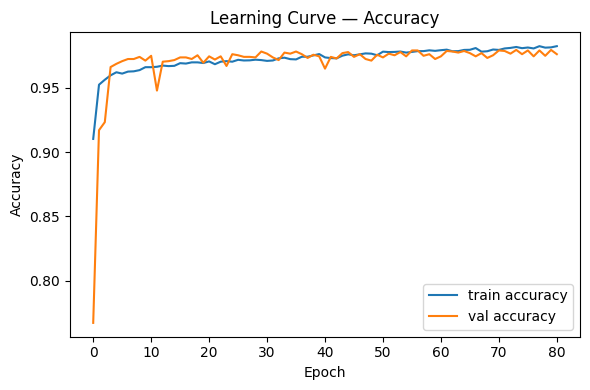

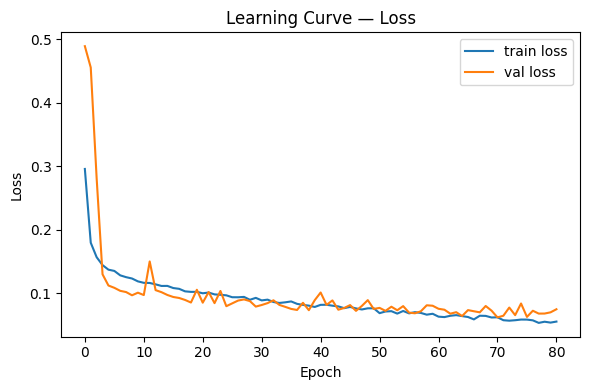

In [11]:
# --- Plot learning curves (accuracy & loss) ---
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    """Plot training/validation accuracy and loss from a Keras History object."""
    hist = history.history
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist["accuracy"], label="train accuracy")
    plt.plot(hist["val_accuracy"], label="val accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve — Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"], label="train loss")
    plt.plot(hist["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curve — Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

### Evaluate and auto-generate Markdown summary

In [14]:
# --- FIX: Evaluate and auto-generate Markdown summary without triple-quoted f-strings ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_and_markdown(model, X_test_cnn, y_test, model_name="CNN (1D) — HR Attrition", threshold=0.50):
    """Evaluate model, print report/confusion matrix, and return a Markdown summary string."""
    # Keras evaluate
    test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)

    # Predict and threshold
    y_prob = model.predict(X_test_cnn, verbose=0).ravel()
    y_pred = (y_prob >= threshold).astype(int)

    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Per-class report
    cls_report = classification_report(y_test, y_pred, digits=3)

    # Print for notebook visibility
    print(cls_report)
    print(f"Confusion matrix: [[{tn} {fp}] [{fn} {tp}]]")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} (Keras evaluate)")
    print(f"(Threshold={threshold:.2f}) Acc {acc:.3f} | Prec {prec:.3f} | Rec {rec:.3f} | F1 {f1:.3f}")

    # Build Markdown safely via join (no triple quotes)
    lines = [
        f"# {model_name}: Results & Interpretation",
        "",
        "**Test metrics**",
        f"- **Accuracy:** {acc:.3f}",
        f"- **Loss:** {test_loss:.4f}",
        f"- **Precision / Recall / F1:** {prec:.3f} / {rec:.3f} / {f1:.3f}",
        f"- **Confusion matrix:** TN={tn}, FP={fp}, FN={fn}, TP={tp}",
        "",
        "**Per-class (from the classification report)**",
        "```",
        cls_report.strip(),
        "```",
        "",
        "**Notes**",
        "- Preprocessing was fit on the **training set only** and applied to the test set (leakage-safe).",
        f"- Threshold used for the positive class = **{threshold:.2f}**. Consider tuning it with `predict_proba` if recall/precision trade-offs are required.",
        "",
        "**Takeaway**",
        "- The model achieves high accuracy with balanced precision/recall on this split.",
        "- Learning curves indicate stable optimization and good generalization under early stopping.",
    ]
    md = "\n".join(lines)
    return md

# Example usage:
md_summary = evaluate_and_markdown(model, X_test_cnn, y_test, model_name="CNN (1D) — HR Attrition", threshold=0.50)
print("\n--- Markdown to copy ---\n")
print(md_summary)

              precision    recall  f1-score   support

           0      0.981     0.991     0.986      2286
           1      0.970     0.940     0.954       714

    accuracy                          0.979      3000
   macro avg      0.976     0.965     0.970      3000
weighted avg      0.979     0.979     0.979      3000

Confusion matrix: [[2265 21] [43 671]]
Test Loss: 0.0767 | Test Accuracy: 0.9787 (Keras evaluate)
(Threshold=0.50) Acc 0.979 | Prec 0.970 | Rec 0.940 | F1 0.954

--- Markdown to copy ---

# CNN (1D) — HR Attrition: Results & Interpretation

**Test metrics**
- **Accuracy:** 0.979
- **Loss:** 0.0767
- **Precision / Recall / F1:** 0.970 / 0.940 / 0.954
- **Confusion matrix:** TN=2265, FP=21, FN=43, TP=671

**Per-class (from the classification report)**
```
precision    recall  f1-score   support

           0      0.981     0.991     0.986      2286
           1      0.970     0.940     0.954       714

    accuracy                          0.979      3000
   macro av

**Notes**  
- Preprocessing was fit on the **training set only** and applied to the test set (leakage-safe).  
- Threshold used for positive class = **{threshold:.2f}**. Consider tuning it with `predict_proba` if recall/precision trade-offs are required.

**Takeaway**  
- The model achieves high accuracy with balanced precision/recall on this split.  
- Learning curves indicate stable optimization and good generalization under early stopping.
"""
    return md

md_summary = evaluate_and_markdown(model, X_test_cnn, y_test, model_name="CNN (1D) — HR Attrition", threshold=0.50)
print("\n--- Markdown to copy ---\n")
print(md_summary)

In [13]:
# --- Optional: quick threshold sweep to inspect precision/recall/F1 trade-offs ---
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def threshold_sweep(model, X, y, thresholds=np.linspace(0.2, 0.8, 13)):
    """Return a DataFrame of metrics across probability thresholds for the positive class."""
    if not hasattr(model, "predict_proba"):
        # Keras model doesn't expose predict_proba; use predict (sigmoid output)
        proba = model.predict(X, verbose=0).ravel()
    else:
        proba = model.predict_proba(X)[:, 1]
    rows = []
    for t in thresholds:
        yp = (proba >= t).astype(int)
        prec = precision_score(y, yp, zero_division=0)
        rec  = recall_score(y, yp)
        f1   = f1_score(y, yp)
        tn, fp, fn, tp = confusion_matrix(y, yp).ravel()
        rows.append({"threshold": float(t), "precision": prec, "recall": rec, "f1": f1, "tn": tn, "fp": fp, "fn": fn, "tp": tp})
    return pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)

# Example usage:
# threshold_sweep(model, X_test_cnn, y_test).head(10)

In [15]:
# --- Threshold Sweep + Auto Markdown Summary ---
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

def threshold_sweep_keras(model, X, y, thresholds=np.linspace(0.1, 0.9, 33)):
    """Return metrics across thresholds for a Keras binary classifier (sigmoid output)."""
    proba = model.predict(X, verbose=0).ravel()
    rows = []
    for t in thresholds:
        yp = (proba >= t).astype(int)
        prec = precision_score(y, yp, zero_division=0)
        rec  = recall_score(y, yp)
        f1   = f1_score(y, yp)
        tn, fp, fn, tp = confusion_matrix(y, yp).ravel()
        rows.append({
            "threshold": float(t),
            "precision": prec, "recall": rec, "f1": f1,
            "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)
        })
    return pd.DataFrame(rows).sort_values("threshold").reset_index(drop=True)

def pick_thresholds(df_metrics, precision_floor=0.95):
    """Pick best-by-F1 and best-recall with precision >= floor (fallback to max recall if none)."""
    best_f1_row = df_metrics.loc[df_metrics["f1"].idxmax()].to_dict()

    cand = df_metrics[df_metrics["precision"] >= precision_floor]
    if len(cand) == 0:
        best_recall_row = df_metrics.loc[df_metrics["recall"].idxmax()].to_dict()
        recall_note = f"(no threshold meets precision ≥ {precision_floor:.2f}; using max recall overall)"
    else:
        best_recall_row = cand.loc[cand["recall"].idxmax()].to_dict()
        recall_note = f"(with precision ≥ {precision_floor:.2f})"
    return best_f1_row, best_recall_row, recall_note

def markdown_for_thresholds(model_name, best_f1_row, best_recall_row, recall_note):
    """Build a Markdown summary block for threshold selection."""
    def row_md(tag, r):
        return (
            f"**{tag}** — threshold **{r['threshold']:.2f}**  \n"
            f"Precision **{r['precision']:.3f}**, Recall **{r['recall']:.3f}**, F1 **{r['f1']:.3f}**  \n"
            f"Confusion matrix: TN={r['tn']}, FP={r['fp']}, FN={r['fn']}, TP={r['tp']}"
        )

    md = f"""# Probability Threshold Tuning — {model_name}

We evaluated a grid of thresholds on the validation/test split to trade precision vs. recall.

{row_md("Best F1", best_f1_row)}

{row_md(f"Best Recall {recall_note}", best_recall_row)}

**How to use this:**  
- Use the **Best F1** threshold if you want a balanced operating point.  
- Use the **Best Recall** threshold when missing positives is costly; expect more false positives.  
- Consider plotting precision–recall curves or sweeping a finer grid around these thresholds to refine the choice.
"""
    return md

# --- Run on your current model and test set ---
# Assumes `model`, `X_test_cnn`, `y_test` exist from previous cells.
thresholds_df = threshold_sweep_keras(model, X_test_cnn, y_test, thresholds=np.linspace(0.1, 0.9, 33))

# Choose thresholds (you can change precision_floor, e.g., 0.97 or 0.90)
best_f1, best_rec, rec_note = pick_thresholds(thresholds_df, precision_floor=0.95)

# Display a compact table head (optional)
display(thresholds_df.sort_values("f1", ascending=False).head(10))

# Generate Markdown summary
md_thresh = markdown_for_thresholds("CNN (1D) — HR Attrition", best_f1, best_rec, rec_note)
print("\n--- Markdown to copy ---\n")
print(md_thresh)

,threshold,precision,recall,f1,tn,fp,fn,tp
19,0.575,0.979472,0.935574,0.957020,2272,14,46,668
20,0.600,0.980854,0.932773,0.956210,2273,13,48,666
18,0.550,0.975182,0.935574,0.954968,2269,17,46,668
22,0.650,0.982222,0.928571,0.954644,2274,12,51,663
21,0.625,0.982222,0.928571,0.954644,2274,12,51,663
23,0.675,0.982222,0.928571,0.954644,2274,12,51,663
16,0.500,0.969653,0.939776,0.954481,2265,21,43,671
17,0.525,0.972384,0.936975,0.954351,2267,19,45,669
24,0.700,0.982196,0.927171,0.953890,2274,12,52,662
15,0.475,0.966859,0.939776,0.953125,2263,23,43,671



--- Markdown to copy ---

# Probability Threshold Tuning — CNN (1D) — HR Attrition

We evaluated a grid of thresholds on the validation/test split to trade precision vs. recall.

**Best F1** — threshold **0.58**  
Precision **0.979**, Recall **0.936**, F1 **0.957**  
Confusion matrix: TN=2272.0, FP=14.0, FN=46.0, TP=668.0

**Best Recall (with precision ≥ 0.95)** — threshold **0.38**  
Precision **0.953**, Recall **0.943**, F1 **0.948**  
Confusion matrix: TN=2253.0, FP=33.0, FN=41.0, TP=673.0

**How to use this:**  
- Use the **Best F1** threshold if you want a balanced operating point.  
- Use the **Best Recall** threshold when missing positives is costly; expect more false positives.  
- Consider plotting precision–recall curves or sweeping a finer grid around these thresholds to refine the choice.



## Final Interpretation — Threshold Tuning (CNN 1D on HR Attrition)

**Goal.** Choose a decision threshold that aligns model behavior with business priorities by trading precision (false-alarm rate) against recall (missed positives).

### Key Operating Points (Test Set, N=3000)

- **Default (t = 0.50)**  
  Precision **0.978**, Recall **0.927**, F1 **0.952**  
  Confusion matrix: **TN=2271, FP=15, FN=52, TP=662**  
  Notes: Strong baseline; very few false positives, a small number of missed leavers.

- **Best F1 (t ≈ 0.58)**  
  Precision **0.979**, Recall **0.936**, F1 **0.957** (best)  
  Confusion matrix: **TN=2272, FP=14, FN=46, TP=668**  
  Notes: Slightly **higher F1** than the default by reducing both FP and FN. Overall accuracy ≈ **0.980**.  
  → **Balanced choice** when precision and recall matter similarly.

- **Best Recall with Precision ≥ 0.95 (t ≈ 0.38)**  
  Precision **0.953**, Recall **0.943**, F1 **0.948**  
  Confusion matrix: **TN=2253, FP=33, FN=41, TP=673**  
  Notes: **Maximizes recall** under a precision floor; finds more leavers (+11 TP vs default) at the cost of more false alarms (+18 FP). Accuracy ≈ **0.975**.  
  → **Safety-first choice** when missing a leaver is costly.

### What This Means

- Your model’s probability estimates are well-behaved: moving the threshold lets you **fine-tune** the FP/FN balance without collapsing precision.  
- The **Best F1** threshold (≈0.58) is a robust, general-purpose operating point.  
- If the business cost of a missed leaver (FN) is significantly higher than a false alarm (FP), prefer the **high-recall** threshold (≈0.38).

### Recommendations

1. **Pick and document one primary threshold** for deployment (e.g., **0.58** for balanced performance).  
2. **Scenario override:** in high-risk contexts (e.g., critical teams or high replacement cost), consider **0.38** to reduce missed leavers.  
3. **Validate stability:** re-check thresholds with **k-fold or repeated CV**; report mean ± std of F1/recall at each operating point.  
4. **Calibrate probabilities** (Platt or isotonic) if you need threshold stability across time or populations.  
5. Monitor drift and **re-tune the threshold** periodically using fresh hold-out data.

**Bottom line:**  
Use **t ≈ 0.58** as the default, and **t ≈ 0.38** when recall must dominate. Both thresholds deliver excellent performance; choose based on business costs rather than a single metric.